## Load the libraries 

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from function_utils import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Define a function to extract features from a single image window
#This function is very similar to extract_features()
#just for a single image rather than list of images

In [2]:
def single_img_features(img, color_space='YUV', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='YUV', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

## Load images

In [21]:
# Read in cars and notcars
cars = glob.glob('../input/vehicles/**/*.png')
notcars = glob.glob('../input/non-vehicles/**/*.png')
print('The size of car images is ', len(cars))
print('The size of non car images is ', len(notcars))

The size of car images is  8792
The size of non car images is  8968


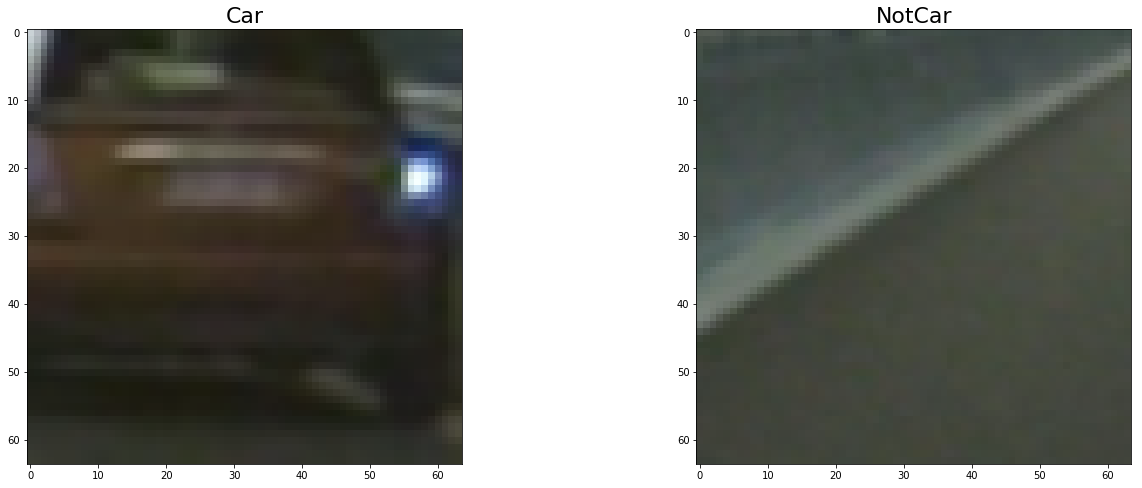

In [4]:
car_exp = cv2.imread(cars[1])
notcar_exp = cv2.imread(notcars[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (22,8))
#fig.tight_layout()
ax1.imshow(car_exp)
ax1.set_title('Car', fontsize=22)
ax2.imshow(notcar_exp)
ax2.set_title('NotCar', fontsize=22)
plt.savefig("../output_images/Car_NotCar.jpg")

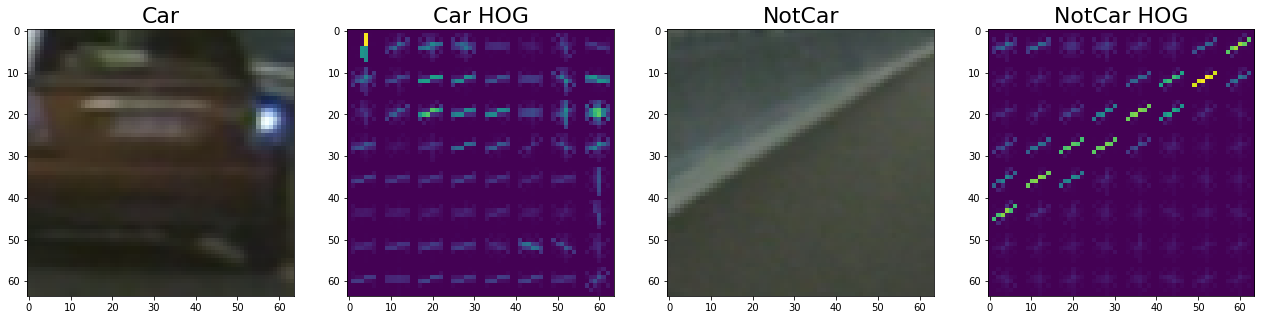

In [49]:
# Set variables for HOG
orient = 11
pix_per_cell = 8
cell_per_block = 2
feature_car_img = cv2.cvtColor(car_exp, cv2.COLOR_RGB2YCrCb)
feature_notcar_img = cv2.cvtColor(notcar_exp, cv2.COLOR_RGB2YCrCb)
car_features, car_hog = get_hog_features(feature_car_img[:,:,0], orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=True, feature_vec=False)
notcar_features, notcar_hog = get_hog_features(feature_notcar_img[:,:,0], orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=True, feature_vec=False)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (22,8))
#fig.tight_layout()
ax1.imshow(car_exp)
ax1.set_title('Car', fontsize=22)
ax2.imshow(car_hog)
ax2.set_title('Car HOG', fontsize=22)
ax3.imshow(notcar_exp)
ax3.set_title('NotCar', fontsize=22)
ax4.imshow(notcar_hog)
ax4.set_title('NotCar HOG', fontsize=22)
plt.savefig("../output_images/Car_NotCar_HOG.jpg")

## Train a SVM classifier

In [50]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 700] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                                   spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = 501
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
 
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5324
27.04 Seconds to train SVC...
Test Accuracy of SVC =  0.9547


In [25]:
cv2.imread(cars[0]).shape[0:2]


(64, 64)

## Scan with different window sizes

(720, 1280, 3)


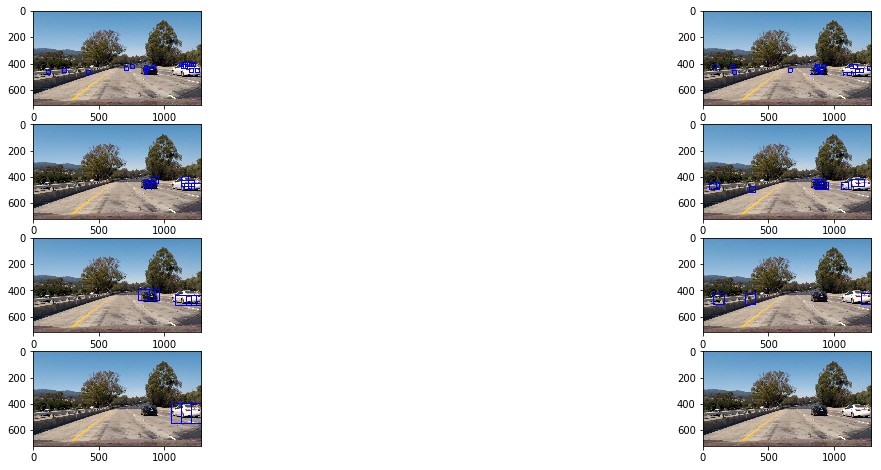

In [67]:
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('../test_images/test1.jpg')
print(image.shape)
# image1 = cv2.resize(image, cv2.imread(cars[0]).shape[0:2])
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

def find_hot_windows(img):
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 0 # Can be 0, 1, 2, or "ALL"
    spatial_size = (32,32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [500, 700] # Min and max in y to search in slide_window()
    x_start_stop=[None, None]
    y_buffer = [[400, 490], [410,500], [400,500],[420,520], [400,560],[430,590], [400,650],[410,710]]
    xy_windows = [(30,30), (30,30), (50,50), (50, 50), (80,80), (80,80), (150,150), (150,150)]
    hot_windows_all = []
    
    for i in range(len(xy_windows)):

        xy_window = xy_windows[i]
        y_start_stop= y_buffer[i]
        windows = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=(0.5, 0.5))
        hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat) 
        hot_windows_all.append(hot_windows)
    return hot_windows_all

hot_windows_all = find_hot_windows(image)  
fig, axes = plt.subplots(4,2, figsize = (22,8))
#fig.tight_layout()
axes = axes.ravel()

#i_label = []
for i in range(len(axes)):
    window_img = draw_boxes(draw_image, hot_windows_all[i], color=(0, 0, 255), thick=6)
    axes[i].imshow(window_img)
#    axes[i].set_title(j for j in xy_windows)
#plt.imshow(window_img)
plt.savefig("../output_images/Scan_road.jpg")

## Combine rectangles

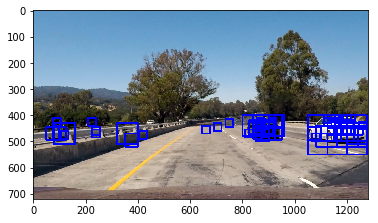

In [68]:
#print(hot_windows_all)
#hot_windows_all.concatenate()
rectangles = [item for sublist in hot_windows_all for item in sublist] 
#print(rectangles)
window_img = draw_boxes(draw_image, rectangles, color=(0, 0, 255), thick=6)
plt.imshow(window_img)
plt.savefig("../output_images/Scan_road_combined.jpg")

## Heatmap, threshold and draw boxes function

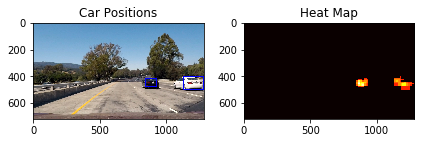

In [70]:
plt.savefig("../output_images/Scan_road.jpg")
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above

# Read in image similar to one shown above 
image = mpimg.imread('../test_images/test1.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,rectangles)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,4)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.savefig("../output_images/Scan_road_heatmap.jpg")

## Process frame pipeline

In [54]:
# Building a image process pipeline

def image_process(img):
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    draw_image = np.copy(img)
    img = img.astype(np.float32)/255

    hot_windows_all = find_hot_windows(img)
    
    rectangles = [item for sublist in hot_windows_all for item in sublist]
    
    # Add heat to each box in box list
    heat = add_heat(heat,rectangles)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_image, labels)
    return draw_img

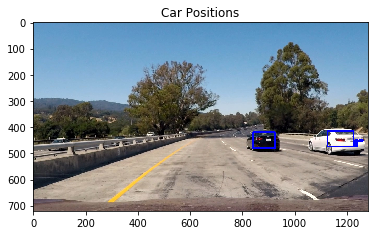

In [55]:
img = mpimg.imread('../test_images/test1.jpg')

output = image_process(img)
plt.figure()
plt.imshow(output)
plt.title('Car Positions')
plt.savefig("../output_images/Scan_road_pipeline.jpg")

## Process video frame by frame

In [56]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [57]:
test_video_output = "../output_videos/test_video_output.mp4"
clip = VideoFileClip("../test_video.mp4")
video_clip = clip.fl_image(image_process)
%time video_clip.write_videofile(test_video_output, audio=False)

[MoviePy] >>>> Building video ../output_videos/test_video_output.mp4
[MoviePy] Writing video ../output_videos/test_video_output.mp4


 97%|█████████▋| 38/39 [02:25<00:03,  3.82s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_videos/test_video_output.mp4 

CPU times: user 2min 22s, sys: 1.02 s, total: 2min 23s
Wall time: 2min 27s


## Video process pipeline

In [58]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        self.recent_rect = []
        self.recent_rect2 = []
        self.recent_rect3 = []
        self.recent_rect4 = []
        self.recent_rect5 = []
        self.heat = []
        
    def add_detect(self, rects):
        threshold = 8
        new_heat = add_heat(self.heat, rects)
        new_heat = add_heat(new_heat, self.recent_rect)
        new_heat = add_heat(new_heat, self.recent_rect2)
        new_heat = add_heat(new_heat, self.recent_rect3)
        new_heat = add_heat(new_heat, self.recent_rect4)
        new_heat = add_heat(new_heat, self.recent_rect5)
        new_heat = apply_threshold(new_heat, threshold=threshold)
        heatmap = np.clip(new_heat, 0, 255)
        labels = label(heatmap)
        bboxes = []
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            bboxes.append((bbox))
        self.prev_rects.append(bboxes)
        if len(self.prev_rects) > 22:
            # Renew the archive
            self.prev_rects = self.prev_rects[len(self.prev_rects)-22:]

In [63]:
# Building a video process pipeline

def video_process(img):
    # Creat heat for threshholding
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    draw_image = np.copy(img)
    img = img.astype(np.float32)/255
    hot_windows_all = find_hot_windows(img)
    
    rectangles = [item for sublist in hot_windows_all for item in sublist]
    veh.heat = heat
    # Get last several frames for smoothing
    if len(veh.prev_rects) > 9:
        veh.recent_rect = veh.prev_rects[-1]
        veh.recent_rect2 = veh.prev_rects[-3]
        veh.recent_rect3 = veh.prev_rects[-5]
        veh.recent_rect4 = veh.prev_rects[-7]
        veh.recent_rect5 = veh.prev_rects[-9]
    # Add detections to archive
    if len(rectangles) > 0:
        veh.add_detect(rectangles)
    
    # Add heat to each box in box list
    for rect_set in veh.prev_rects:
        heat = add_heat(heat, rect_set)
    heat = apply_threshold(heat, 2 + len(veh.prev_rects)//2)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_image, labels)
    return draw_img

In [71]:
veh = Vehicle_Detect()

test_video_output = "../output_videos/test_video_output2.mp4"
clip = VideoFileClip("../test_video.mp4")
video_clip2 = clip.fl_image(video_process)
%time video_clip2.write_videofile(test_video_output, audio=False)

[MoviePy] >>>> Building video ../output_videos/test_video_output2.mp4
[MoviePy] Writing video ../output_videos/test_video_output2.mp4



 97%|█████████▋| 38/39 [02:14<00:03,  3.54s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_videos/test_video_output2.mp4 

CPU times: user 2min 13s, sys: 611 ms, total: 2min 14s
Wall time: 2min 16s


In [66]:
veh = Vehicle_Detect()

test_video_output = "../output_videos/project_video_output.mp4"
clip = VideoFileClip("../project_video.mp4")
video_clip3 = clip.fl_image(video_process)
%time video_clip3.write_videofile(test_video_output, audio=False)

[MoviePy] >>>> Building video ../output_videos/project_video_output.mp4
[MoviePy] Writing video ../output_videos/project_video_output.mp4



 12%|█▏        | 147/1261 [11:05<1:24:01,  4.53s/it]


 23%|██▎       | 293/1261 [21:31<1:11:05,  4.41s/it]


 35%|███▍      | 440/1261 [31:33<58:52,  4.30s/it]


 47%|████▋     | 591/1261 [42:20<47:59,  4.30s/it]


 59%|█████▉    | 742/1261 [53:00<37:04,  4.29s/it]


 71%|███████   | 891/1261 [1:03:19<26:17,  4.26s/it]


 82%|████████▏ | 1036/1261 [1:13:17<15:55,  4.24s/it]


 93%|█████████▎| 1179/1261 [1:23:13<05:47,  4.24s/it]


100%|█████████▉| 1260/1261 [1:28:29<00:04,  4.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_videos/project_video_output.mp4 

CPU times: user 1h 21min 39s, sys: 46.7 s, total: 1h 22min 25s
Wall time: 1h 28min 31s
